# Protein embeddings improve phage-host interaction prediction

**Mark Edward M. Gonzales<sup>1, 2</sup>, Jennifer C. Ureta<sup>1, 2</sup> & Anish M.S. Shrestha<sup>1, 2</sup>**

<sup>1</sup> Bioinformatics Laboratory, Advanced Research Institute for Informatics, Computing and Networking, De La Salle University, Manila, Philippines <br>
<sup>2</sup> Department of Software Technology, College of Computer Studies, De La Salle University, Manila, Philippines 

{mark_gonzales, jennifer.ureta, anish.shrestha}@dlsu.edu.ph

<hr>

## 💡 Embeddings & Consolidated Data

This notebook assumes that you have generated (or downloaded) the following directories:

- **Protein Embeddings**
   - Refer to [`4. Protein Embedding Generation.ipynb`](https://github.com/bioinfodlsu/phage-host-prediction/blob/main/experiments/4.%20Protein%20Embedding%20Generation.ipynb) for the script to generate these embeddings.
   - Alternatively, you may download the protein embeddings from these Google Drive directories: [Part 1](https://drive.google.com/drive/folders/1deenrDQIr3xcl9QCYH-nPhmpY8x2drQw?usp=sharing) and [Part 2](https://drive.google.com/drive/folders/1jnBFNsC6zJISkc6IAz56257MSXKjY0Ez?usp=sharing). Consolidate the downloaded folders into a single `embeddings` directory and save it inside the `inphared` directory located in the same folder as this notebook. The folder structure should look like this:

        `experiments` (parent folder of this notebook) <br> 
        ↳ `inphared` <br>
        &nbsp; &nbsp;↳ `embeddings` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ `esm` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ `esm1b` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ ... <br>
        ↳ `2. Exploratory Data Analysis.ipynb` (this notebook) <br>

        However, technically, you only need the embeddings saved in `inphared/embeddings/prottransbert/rbp` to run this notebook. <br><br>
    
- **Consolidated Data**
   - Refer to [`5. Data Consolidation.ipynb`](https://github.com/bioinfodlsu/phage-host-prediction/blob/main/experiments/5.%20Data%20Consolidation.ipynb) for the script to generate the consolidated data.
   - Alternatively, you may download the consolidated data from [Google Drive](https://drive.google.com/drive/folders/1xNoA6dxkN4jzVNCg_7YNjdPZzl51Jo9M?usp=sharing). Save the downloaded `data` folder inside the `inphared` directory located in the same folder as this notebook. The folder structure should look like this:

        `experiments` (parent folder of this notebook) <br> 
        ↳ `inphared` <br>
        &nbsp; &nbsp;↳ `data` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp.csv` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp_embeddings_esm.csv` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ ... <br>
        &nbsp; &nbsp;↳ `embeddings` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ `esm` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ `esm1b` <br>
        &nbsp; &nbsp;&nbsp; &nbsp; ↳ ... <br>
        ↳ `2. Exploratory Data Analysis.ipynb` (this notebook) <br>
        
        However, technically, you only need `inphared/data/rbp_embeddings_prott5.csv` to run this notebook.

<hr>

## Part I: Preliminaries

Import the necessary libraries and modules.

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ConstantsUtil import ConstantsUtil
from EDAUtil import EDAUtil
from ClassificationUtil import ClassificationUtil

%load_ext autoreload
%autoreload 2

In [2]:
constants = ConstantsUtil()
eda_util = EDAUtil()
class_util = ClassificationUtil(complete_embeddings_dir = constants.COMPLETE_EMBEDDINGS)

<hr>

## Part II: RBP Length Distribution

Compute the lower and upper bounds for RBP lengths (in order to discard outliers).

In [3]:
with open(f'{constants.TEMP_PREPROCESSING}/{constants.RBP_LENGTHS}','rb') as rbp_lengths_file:
    lengths = pickle.load(rbp_lengths_file)

Q1 = np.percentile(lengths, 25, interpolation = 'midpoint')
Q3 = np.percentile(lengths, 75, interpolation = 'midpoint')
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Annotated RBPs selected based on the coding sequence information in GenBank and the functional annotation obtained using PHROG (**prior to removing outliers**)

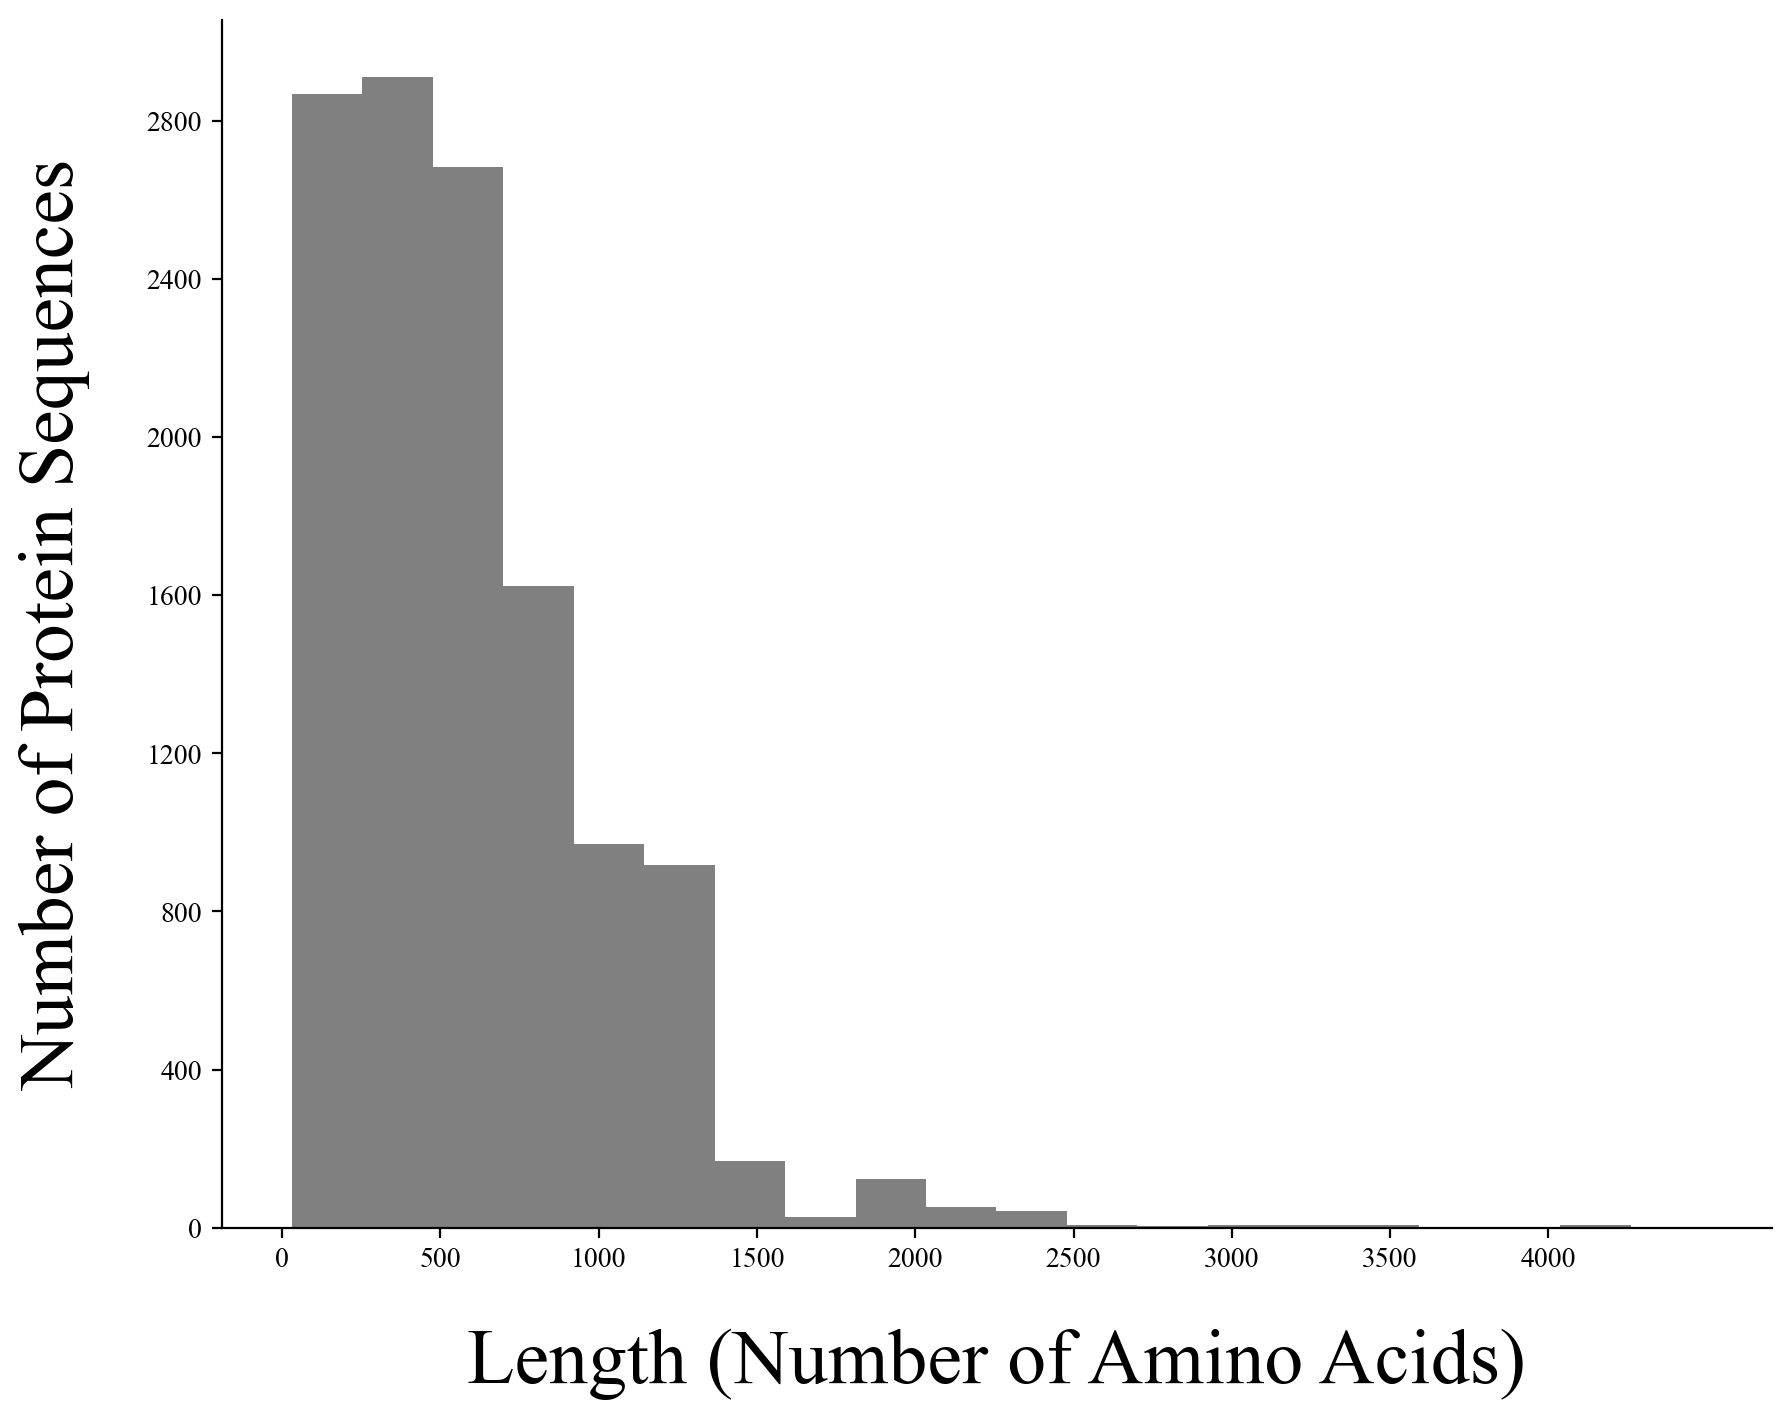

In [4]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22

fig, ax = plt.subplots(figsize=(10,8), dpi=200)
plt.hist(lengths, bins = 20, color = 'gray')
plt.yticks(np.arange(0, 3200, 400))
plt.xticks(np.arange(0, 4500, 500))
plt.xlabel('Length (Number of Amino Acids)', labelpad = 20, fontsize = 28)
plt.ylabel('Number of Protein Sequences', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.show()

Annotated RBPs selected based on the coding sequence information in GenBank and the functional annotation obtained using PHROG (**after removing outliers**)

In [5]:
lengths_no_outliers = []
for length in lengths:
    if length <= upper_bound:
        lengths_no_outliers.append(length)

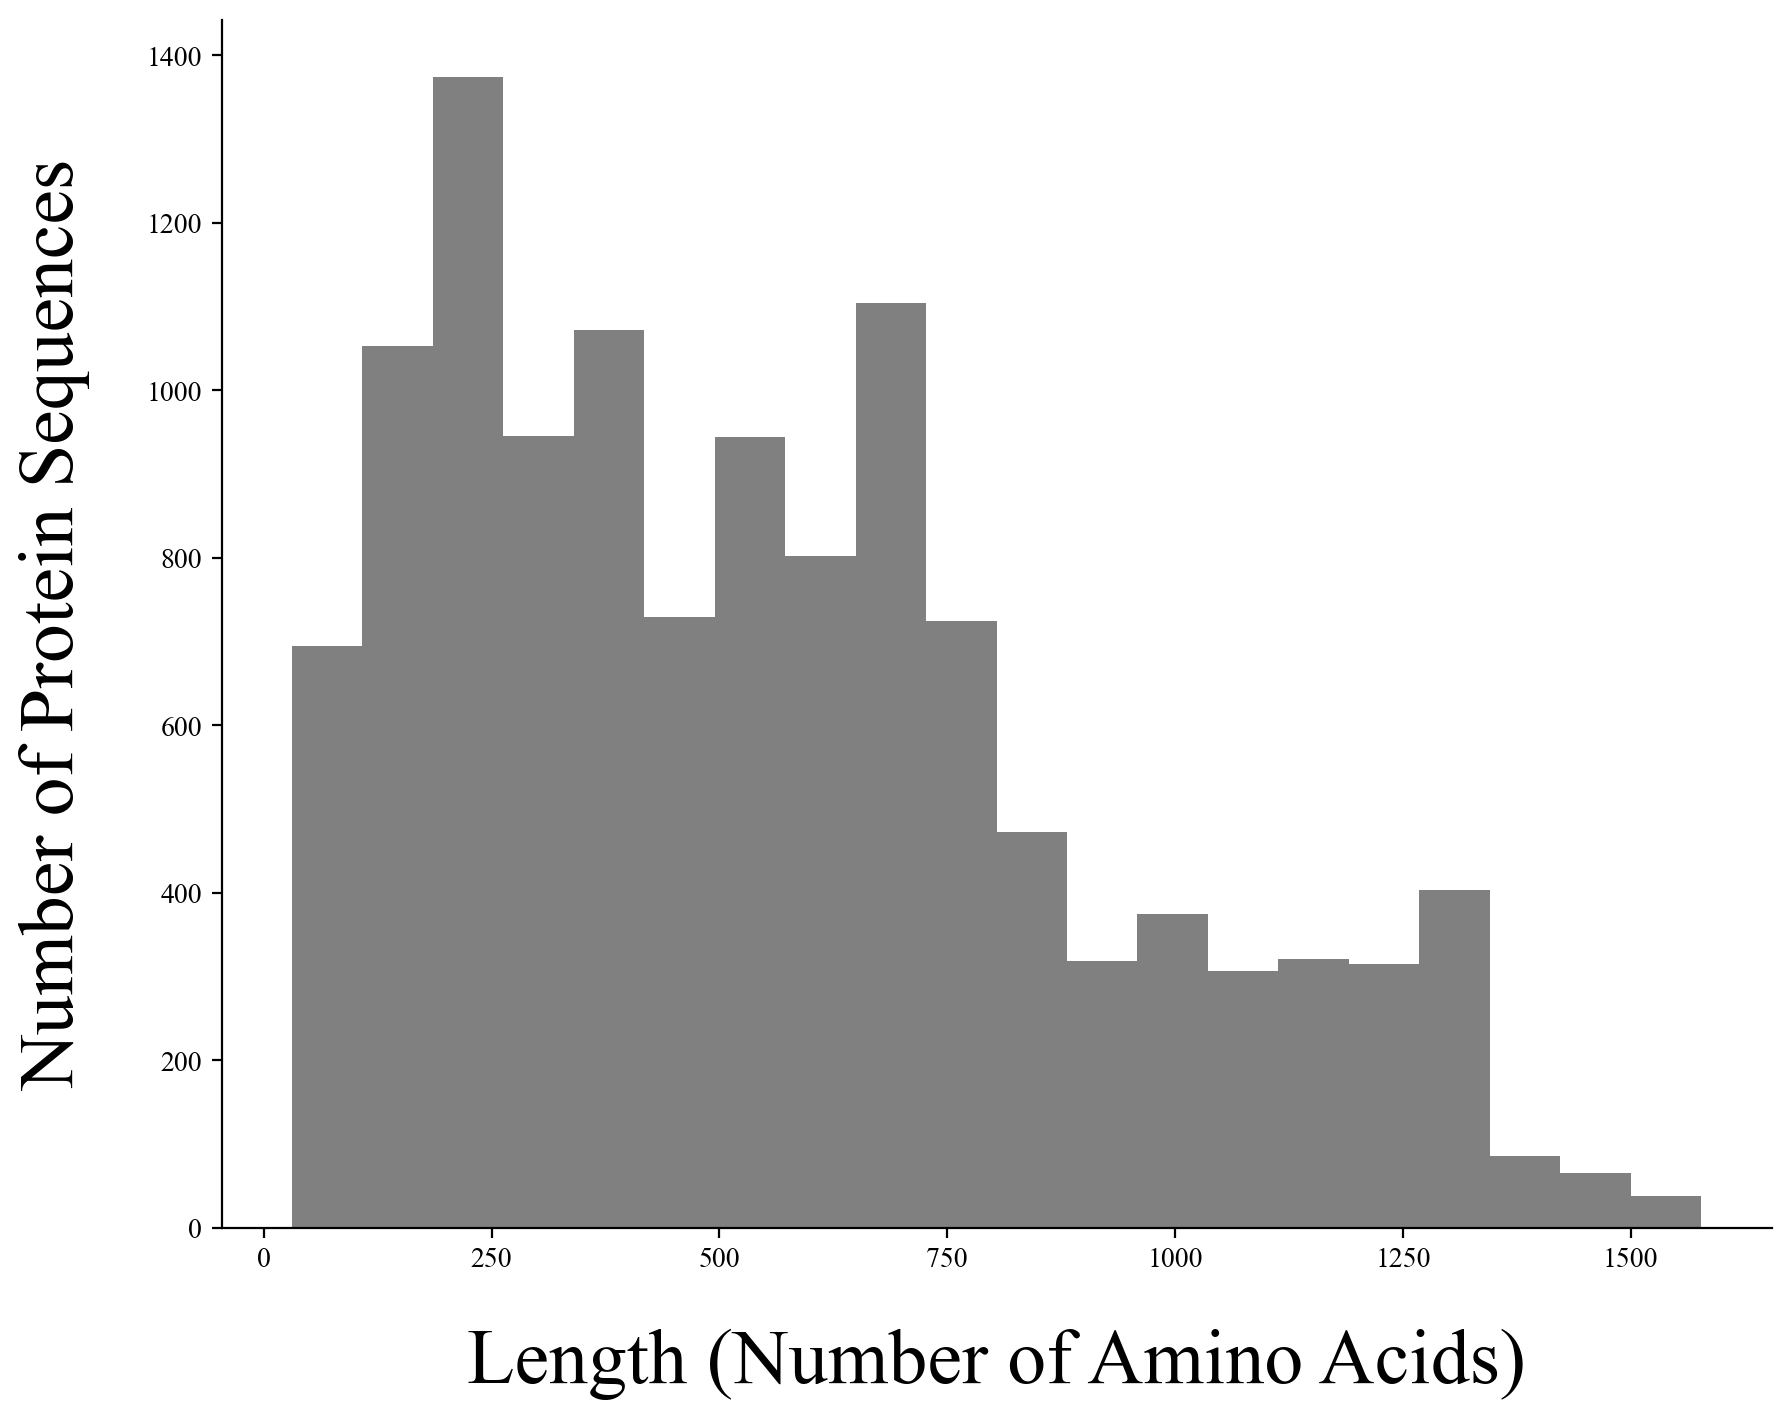

In [6]:
fig, ax = plt.subplots(figsize=(10,8), dpi=200)
plt.hist(lengths_no_outliers, bins = 20, color = 'gray')
plt.yticks(np.arange(0, 1600, 200))
plt.xticks(np.arange(0, 1750, 250))
plt.xlabel('Length (Number of Amino Acids)', labelpad = 20, fontsize = 28)
plt.ylabel('Number of Protein Sequences', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.show()

All the RBPs in our dataset, including those computationally predicted via the approach proposed by [Boeckaerts <i>et al.</i>](https://www.mdpi.com/1999-4915/14/6/1329) (2022)

In [7]:
rbp_df = pd.read_csv(f'{constants.INPHARED}/{constants.DATA}/{constants.PLM_EMBEDDINGS_CSV["PROTT5"]}')

all_lengths = []
for x in rbp_df['Protein Sequence']:
    all_lengths.append(len(x))

C:\Users\Edward\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (13,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


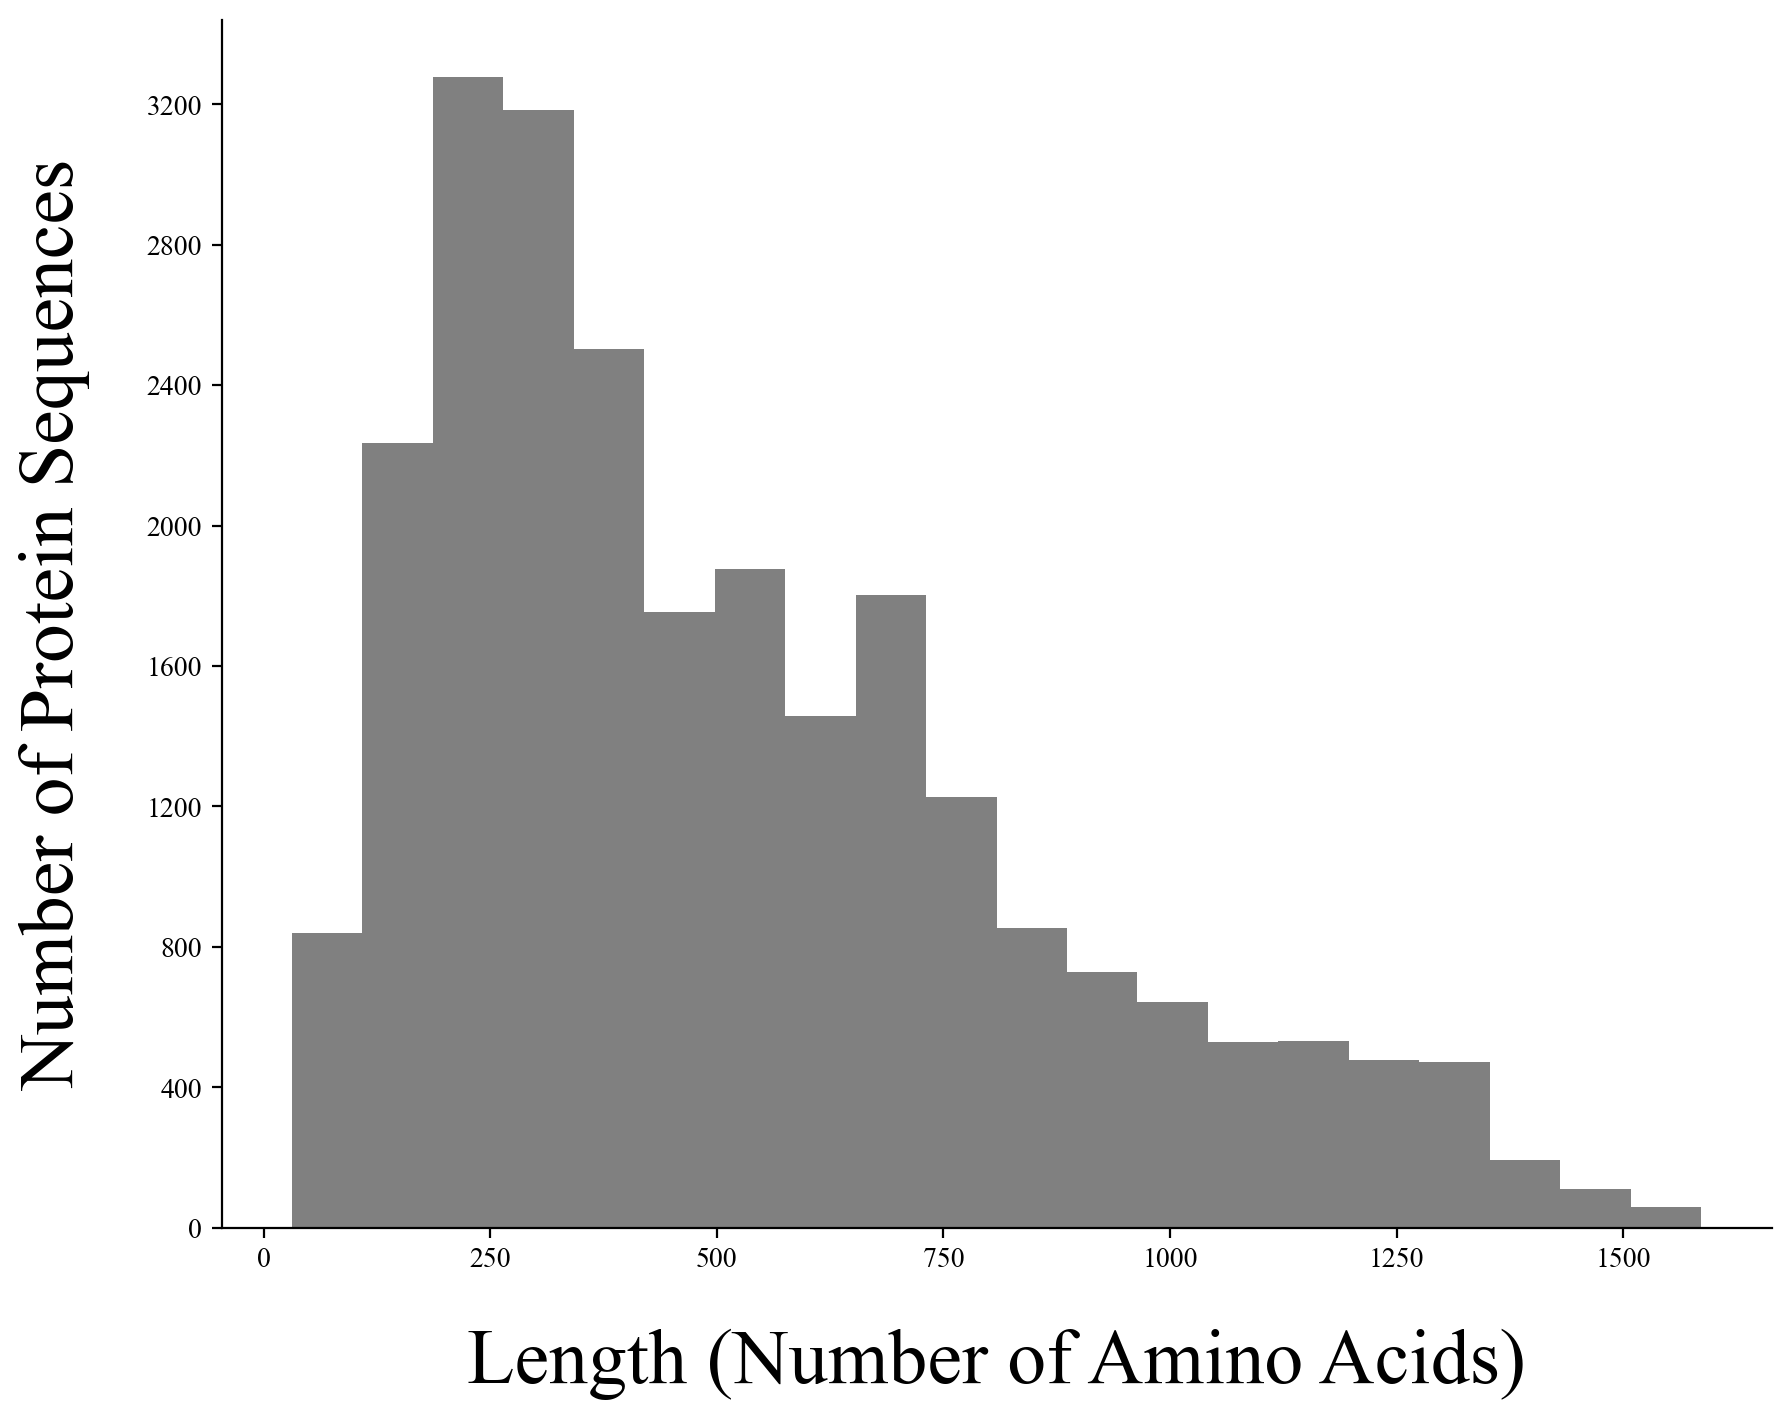

In [8]:
fig, ax = plt.subplots(figsize=(10,8), dpi=200)
plt.hist(all_lengths, bins = 20, color = 'gray')
plt.yticks(np.arange(0, 3600, 400))
plt.xticks(np.arange(0, 1750, 250))
plt.xlabel('Length (Number of Amino Acids)', labelpad = 20, fontsize = 28)
plt.ylabel('Number of Protein Sequences', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.show()

<hr>

## Part III: Statistics on Counts

Get all the RBPs in our dataset

In [9]:
rbps = class_util.get_rbps()

In [10]:
print("RBPs:", len(rbps))
print("Phages:", rbp_df['Accession'].nunique())
print("Hosts:", rbp_df['Host'].nunique())

RBPs: 24752
Phages: 9583
Hosts: 232


Annotated RBPs selected based on the coding sequence information in GenBank, excluding those with outlying lengths

In [11]:
rbps_genbank = eda_util.get_rbps(f'{constants.INPHARED}/{constants.PLM["PROTTRANSBERT"]}/{constants.RBP}/{constants.GENBANK}')
rbps_genbank

['BAF34053.1',
 'BAF63353.1',
 'BAF80734.1',
 'BAF98834.1',
 'BAG12617.1',
 'BAG70396.1',
 'BAK78927.1',
 'BAJ51834.1',
 'BAK52966.1',
 'BAK52975.1',
 'BAM20890.1',
 'BAP15740.1',
 'BAN05354.1',
 'BAN05355.1',
 'BAM63083.1',
 'BAM63132.1',
 'BAM68856.1',
 'BAM68862.1',
 'BAO20711.1',
 'BAN92354.1',
 'BAO04678.1',
 'BAQ02805.1',
 'BAQ02835.1',
 'BAQ02836.1',
 'BAQ02837.1',
 'BAQ02838.1',
 'BAQ02839.1',
 'BAQ02841.1',
 'BAQ02842.1',
 'BAQ02844.1',
 'BAO47121.1',
 'BAS32846.1',
 'BAP15843.1',
 'BAP34930.1',
 'AAF31093.1',
 'AAF31111.1',
 'AAF01127.1',
 'AAD25464.1',
 'AAD42417.1',
 'AAD42460.1',
 'AAQ14803.1',
 'AAQ14804.1',
 'AAK28905.1',
 'AGA17894.1',
 'AAL82278.1',
 'AAO73174.1',
 'AAM81383.1',
 'CAB63638.1',
 'CAB93927.2',
 'CAC83572.1',
 'CAC83574.1',
 'CAH23261.1',
 'CAC86305.1',
 'CAD44229.1',
 'CAD44231.1',
 'CAD88876.2',
 'CAD90831.1',
 'CAD91785.1',
 'CAE82146.1',
 'CAF34284.1',
 'CAF34289.1',
 'CCE26317.1',
 'CCE26321.1',
 'CAJ28476.1',
 'CAJ28477.1',
 'CAJ28479.1',
 'CAJ42247

In [12]:
rbps_genbank_df = pd.DataFrame(rbps_genbank, columns = ['Protein ID'])
rbps_genbank_df_merged = pd.merge(rbps_genbank_df, rbp_df, how = 'inner', validate = 'one_to_one')
rbps_genbank_df_merged.head()

,Protein ID,Accession,Description,Classification,Genome Length (bp),Jumbophage,molGC (%),Molecule,Modification Date,Number CDS,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,BAF34053.1,AB255436,Stx2-converting phage 86,Stx2-converting phage 86 Traversvirus tv86 Tra...,60238,False,49.067,DNA,2009-01-27,79,...,-0.037941,-0.027003,-0.015986,-0.058939,0.034676,-0.002194,-0.046527,0.005231,0.040603,-0.000655
1,BAF63353.1,AB285204,Enterobacteria phage cdtI,Enterobacteria phage cdtI Siphoviridae Caudovi...,47021,False,49.116,DNA,2008-12-02,55,...,-0.061362,-0.017272,-0.017381,-0.003055,0.027018,-0.034796,-0.040106,0.016259,-0.009375,-0.014899
2,BAF80734.1,AB362338,Salmonella phage P22,Salmonella phage P22 Lederbergvirus Caudoviric...,41660,False,47.012,DNA,2008-12-02,65,...,0.041153,0.021408,0.003260,-0.046062,0.052537,0.011491,-0.012216,0.024775,0.075963,0.004407
3,BAF98834.1,AB374228,Vibrio phage Kappa,Vibrio phage Kappa Longwoodvirus Peduoviridae ...,33507,False,48.835,DNA,2008-01-16,44,...,-0.001410,0.034112,-0.055453,-0.079701,0.042038,0.042043,0.020816,0.000974,0.070224,-0.006129
4,BAG12617.1,AB426868,Salmonella phage P22,Salmonella phage P22 Lederbergvirus Caudoviric...,41660,False,47.012,DNA,2008-12-03,65,...,0.041153,0.021408,0.003260,-0.046062,0.052537,0.011491,-0.012216,0.024775,0.075963,0.004407


In [13]:
print("RBPs:", len(rbps_genbank))
print("Phages:", rbps_genbank_df_merged['Accession'].nunique())
print("Hosts:", rbps_genbank_df_merged['Host'].nunique())

RBPs: 11133
Phages: 5805
Hosts: 167


Annotated RBPs selected based on the functional annotation obtained using PHROG

In [14]:
rbps_prokka = eda_util.get_rbps(f'{constants.INPHARED}/{constants.PLM["PROTTRANSBERT"]}/{constants.RBP}/{constants.PROKKA}')
rbps_prokka

['AY526908_00022',
 'AY526909_00022',
 'CP013974_00009',
 'CP013974_00016',
 'CP013974_00053',
 'CP013974_00060',
 'CP017837_00040',
 'CP018841_00030',
 'CP018841_00029',
 'CP025874_00013',
 'CP025874_00016',
 'CP025902_00003',
 'CP025902_00004',
 'CP025907_00027',
 'CP025907_00029',
 'CP025923_00035',
 'CP025923_00038',
 'CP038007_00053',
 'CP051272_00015',
 'CP051272_00016',
 'CP051272_00017',
 'CP051272_00018',
 'CP051272_00019',
 'CP051275_00011',
 'CP051278_00015',
 'CP051279_00018',
 'CP051279_00019',
 'CP051285_00018',
 'CP051288_00040',
 'CP053388_00045',
 'CP054387_00045',
 'CP058330_00009',
 'CP059058_00055',
 'CP060690_00003',
 'CP062422_00024',
 'CP062422_00020',
 'CP062427_00060',
 'CP062427_00064',
 'CP062434_00019',
 'CP062442_00019',
 'CP062444_00019',
 'CP062451_00005',
 'CP062451_00001',
 'CP062454_00056',
 'CP062454_00052',
 'CP062461_00019',
 'CP062462_00025',
 'CP062462_00021',
 'CP062992_00153',
 'CP062992_00154',
 'CP067347_00126',
 'CP067347_00169',
 'CP067352_0

In [15]:
rbps_prokka_df = pd.DataFrame(rbps_prokka, columns = ['Protein ID'])
rbps_prokka_df_merged = pd.merge(rbps_prokka_df, rbp_df, how = 'inner', validate = 'one_to_one')
rbps_prokka_df_merged.head()

,Protein ID,Accession,Description,Classification,Genome Length (bp),Jumbophage,molGC (%),Molecule,Modification Date,Number CDS,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,AY526908_00022,AY526908,Bordetella phage BMP-1,Bordetella phage BMP-1 Rauchvirus Caudoviricet...,42663,False,65.438,DNA,2004-03-09,50,...,-0.047147,0.003369,0.015210,-0.085593,0.001137,0.031133,0.010755,0.018820,0.014403,-0.014608
1,AY526909_00022,AY526909,Bordetella phage BIP-1,Bordetella phage BIP-1 Rauchvirus Caudoviricet...,42638,False,65.402,DNA,2004-03-09,50,...,-0.047147,0.003369,0.015210,-0.085593,0.001137,0.031133,0.010755,0.018820,0.014403,-0.014608
2,CP013974_00009,CP013974,Erwinia phage LS-2018a,Erwinia phage LS-2018a Myoviridae Caudoviricet...,59759,False,51.017,DNA,2018-07-24,82,...,0.028448,0.021578,-0.017302,-0.042378,-0.024442,0.011080,0.023264,0.022059,0.005250,0.027027
3,CP013974_00016,CP013974,Erwinia phage LS-2018a,Erwinia phage LS-2018a Myoviridae Caudoviricet...,59759,False,51.017,DNA,2018-07-24,82,...,-0.003774,0.023006,-0.036779,-0.034177,0.068803,0.011976,0.005535,0.000274,-0.005250,-0.057383
4,CP013974_00053,CP013974,Erwinia phage LS-2018a,Erwinia phage LS-2018a Myoviridae Caudoviricet...,59759,False,51.017,DNA,2018-07-24,82,...,0.028448,0.021578,-0.017302,-0.042378,-0.024442,0.011080,0.023264,0.022059,0.005250,0.027027


In [16]:
print("RBPs:", len(rbps_prokka))
print("Phages:", rbps_prokka_df_merged['Accession'].nunique())
print("Hosts:", rbps_prokka_df_merged['Host'].nunique())

RBPs: 1010
Phages: 419
Hosts: 30


RBPs computationally predicted via the approach proposed by [Boeckaerts <i>et al.</i>](https://www.mdpi.com/1999-4915/14/6/1329) (2022)

In [17]:
rbps_predicted = []

for rbp in rbps:
    if rbp[0] not in rbps_genbank and rbp[0] not in rbps_prokka:
        rbps_predicted.append(rbp[0])

In [18]:
rbps_predicted_df = pd.DataFrame(rbps_predicted, columns = ['Protein ID'])
rbps_predicted_df_merged = pd.merge(rbps_predicted_df, rbp_df, how = 'inner', validate = 'one_to_one')
rbps_predicted_df_merged.head()

,Protein ID,Accession,Description,Classification,Genome Length (bp),Jumbophage,molGC (%),Molecule,Modification Date,Number CDS,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,BAF36105.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,...,-0.024003,-0.029409,0.013041,-0.025576,0.000868,0.053601,0.028784,-0.014681,0.029822,-0.063528
1,BAF36110.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,...,-0.061395,0.019466,0.023357,-0.049386,0.012918,0.052622,0.025504,0.011063,0.043035,0.057878
2,BAF36131.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,...,-0.050904,-0.006077,0.025978,-0.019343,-0.008771,0.047186,0.048965,-0.010241,0.038061,-0.004695
3,BAF36132.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,...,-0.052231,-0.007240,-0.034144,-0.084727,0.018650,0.052715,0.021225,0.021085,0.053816,-0.011411
4,BAF36193.1,AB231700,Microcystis virus Ma-LMM01,Microcystis virus Ma-LMM01 Fukuivirus Caudovir...,162109,False,45.953,DNA,2021-07-14,189,...,0.028329,-0.019079,0.018484,0.006488,0.022265,0.029314,-0.009222,0.017038,0.040056,0.018588


In [19]:
print("RBPs:", len(rbps_predicted))
print("Phages:", rbps_predicted_df_merged['Accession'].nunique())
print("Hosts:", rbps_predicted_df_merged['Host'].nunique())

RBPs: 12609
Phages: 5941
Hosts: 192
